In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 13)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def nice_plot(ax):
    ax.set(xlabel="$x$", ylabel="$y$")
    ax.axhline(0, color="black")
    ax.axvline(0, color="black")
    ax.grid(alpha=0.5)

### 6.1 Overfitting

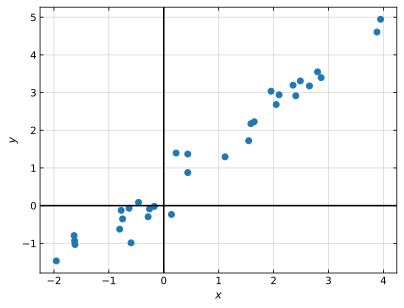

In [3]:
# Generating data with noise
def linear(x, w=1.0, b=0.5):
    return w*x + b
xs_train = torch.rand(32)*6 - 2
ys_train = linear(xs_train) + 0.5*torch.randn(32)

fig, ax = plt.subplots()
ax.plot(xs_train, ys_train, "o")
nice_plot(ax)

fig.savefig('ex52_fig1.png')

**Make two different PyTorch models**

One which knows about the underlying functional form of the data, i.e. $y=wx+b$, with w and b as learnable parameters


One that is ignorant about the underlying function form of the data, and rather just has many adjustable parameters, e.g. a deep neural network composed of
* an input $1 \times 8$-layer with ReLU-activation
* two hidden $8 \times 8$ layers each with ReLU-activation
* an output $8 \times 1$-layer

In [4]:
class LinearModel(torch.nn.Module):
    def __init__(self, w=1.0, b=0.5):
        super().__init__()
        self.w = torch.nn.Parameter(torch.tensor(float(w)))
        self.b = torch.nn.Parameter(torch.tensor(float(b)))
        self.linear = torch.nn.Linear(1, 1)

    def forward(self, x):
        x = x.view(-1, 1)
        x = self.linear(x)
        return x.flatten()

class DeepModel(torch.nn.Module):
    def __init__(self, activation, N_hidden, layer_size):
        super().__init__()
        if activation.lower() == 'relu':
            self.activation = torch.relu
        elif activation.lower() == 'silu':
            self.activation = torch.nn.SiLU()
        self.input_layer = torch.nn.Linear(1, layer_size)
        self.hidden_layers = torch.nn.ModuleList([torch.nn.Linear(layer_size, layer_size) for _ in range(N_hidden)])
        self.output_layer = torch.nn.Linear(layer_size, 1)

    def forward(self, x):
        x = x.view(-1, 1)
        x = self.input_layer(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
        x = self.output_layer(x)
        return x.flatten()

def train(model, x_train, y_train, lr=0.001, steps=10000, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    loss = torch.nn.MSELoss()

    for i in tqdm(range(steps), desc='Training'):
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss_value = loss(y_pred, y_train)
        loss_value.backward()
        optimizer.step()

        # if i % max(1, steps//4) == 0 or i == steps-1:
        #     print(f'Step: {i}, Loss: {loss_value.item()}')
    
    return float(loss_value.item())

Training: 100%|██████████| 10000/10000 [00:15<00:00, 626.73it/s]


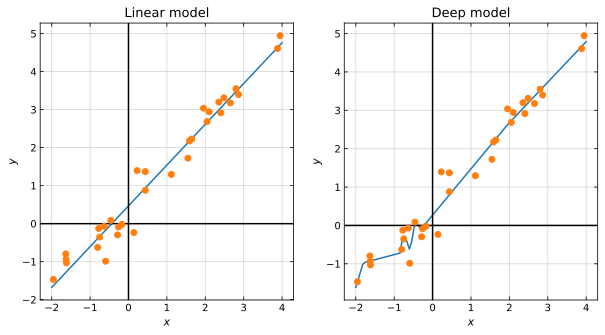

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10,5))
xs = torch.linspace(-2, 4, 100)
linear_model = LinearModel(w=1.0, b=0.5)
deep_model = DeepModel(activation='ReLU', N_hidden=2, layer_size=8)
models = [linear_model, deep_model]

for ax, model in zip(axs.flatten(), models):
    loss_value = train(model, xs_train, ys_train)
    with torch.no_grad():
        ax.plot(xs, model(xs))
    nice_plot(ax)
    ax.plot(xs_train, ys_train, 'o')

axs[0].set_title('Linear model')
axs[1].set_title('Deep model')

fig.savefig('ex52_fig2.png')

### 6.2 Regularization

<>:21: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Jakob\AppData\Local\Temp\ipykernel_20084\3679053260.py:21: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f'Deep model with L2 regularization, $\gamma$={wd}')
Training: 100%|██████████| 10000/10000 [00:12<00:00, 805.17it/s]


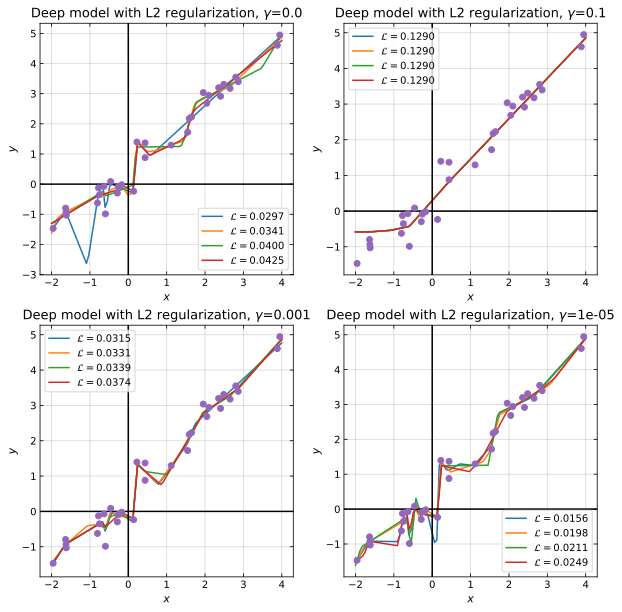

In [6]:
# Investigate the effect of adding L2 regularization of the parameters of the deep neural network.
# Since the final, trained models are stochastic (due to the random initialization of the network parameters),
# you will need to do several runs for each level of regularization and only consider some of the best models obtained.

fig, axs = plt.subplots(2, 2, figsize=(10,10))
weight_decays = [0.0, 0.1, 0.001, 1e-5]

for ax, wd in zip(axs.flatten(), weight_decays):
    loss_values = []
    models = []
    for _ in range(10):
        model = DeepModel(activation='ReLU', N_hidden=2, layer_size=8)
        loss_value = train(model, xs_train, ys_train, wd=wd)
        loss_values.append(loss_value)
        models.append(model)
    sorted_list = sorted(zip(loss_values, models))
    for loss_value, model in sorted_list[:4]:
        with torch.no_grad():
            ax.plot(xs, model(xs), label=fr'$\mathcal{{L}} = {loss_value:.4f}$')
    nice_plot(ax)
    ax.set_title(f'Deep model with L2 regularization, $\gamma$={wd}')
    ax.legend()
    ax.plot(xs_train, ys_train, 'o')

fig.savefig('ex52_fig3.png')